In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve,auc 

In [2]:
df = pd.read_csv("./Group_7_data_cleaned.csv")

In [3]:
df.drop(columns=['Date','Time'], inplace=True)

In [4]:
df.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.77,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.65,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.52,0,0,1
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.39,0,0,1
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.25,0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               10129 non-null  float64
 1   S2_Temp               10129 non-null  float64
 2   S3_Temp               10129 non-null  float64
 3   S4_Temp               10129 non-null  float64
 4   S1_Light              10129 non-null  int64  
 5   S2_Light              10129 non-null  int64  
 6   S3_Light              10129 non-null  int64  
 7   S4_Light              10129 non-null  int64  
 8   S1_Sound              10129 non-null  float64
 9   S2_Sound              10129 non-null  float64
 10  S3_Sound              10129 non-null  float64
 11  S4_Sound              10129 non-null  float64
 12  S5_CO2                10129 non-null  int64  
 13  S5_CO2_Slope          10129 non-null  float64
 14  S6_PIR                10129 non-null  int64  
 15  S7_PIR             

## Estimating the Occupancy of the room after removing the light input variables as per problem statement

In [6]:
df_wo_light = df.drop(df.filter(regex='Light').columns, axis=1)

In [7]:
df_wo_light.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,0.08,0.19,0.06,0.06,390,0.77,0,0,1
1,24.94,24.75,24.56,25.44,0.93,0.05,0.06,0.06,390,0.65,0,0,1
2,25.00,24.75,24.50,25.44,0.43,0.11,0.08,0.06,390,0.52,0,0,1
3,25.00,24.75,24.56,25.44,0.41,0.10,0.10,0.09,390,0.39,0,0,1
4,25.00,24.75,24.56,25.44,0.18,0.06,0.06,0.06,390,0.25,0,0,1


In [8]:
X_wo_light = df_wo_light.drop(['Room_Occupancy_Count'], axis=1)
y_wo_light = df_wo_light[['Room_Occupancy_Count']]

In [9]:
# Splitting the dataset into train and test
X_train_wo_light, X_test_wo_light, y_train_wo_light, y_test_wo_light = train_test_split(X_wo_light, y_wo_light, test_size=0.2, random_state=42)

In [10]:
model_classs_wo_light = DecisionTreeClassifier(random_state=42)
model_classs_wo_light.fit(X_train_wo_light, y_train_wo_light)

print("Accuracy on train set: ", model_classs_wo_light.score(X_train_wo_light, y_train_wo_light))
print("Accuracy on test set: ", model_classs_wo_light.score(X_test_wo_light, y_test_wo_light))

Accuracy on train set:  1.0
Accuracy on test set:  0.9846989141164857


### Hyperparameter Tuning using GridSearch

In [11]:
%%time

# define grid search
grid = {
    "criterion" : ['gini', 'entropy'],
    "max_depth": [5,8,10,11,12,13,14,15],
    "max_leaf_nodes": [35,38,40,42,45,50],
    "min_samples_split": [2,5,10,20,30,40],
    "min_samples_leaf": [2,20,40,50]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model_classs_wo_light, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = cv, 
                           scoring = 'accuracy',
                           error_score = 0,
                           verbose = 1
                          )

grid_result = grid_search.fit(X_test_wo_light, y_test_wo_light)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 15 folds for each of 2304 candidates, totalling 34560 fits
Best: 0.959856 using {'criterion': 'entropy', 'max_depth': 12, 'max_leaf_nodes': 40, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.942586 (0.014894) with: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 35, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.941928 (0.014820) with: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 35, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.940611 (0.014869) with: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 35, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.938799 (0.015013) with: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 35, 'min_samples_leaf': 2, 'min_samples_split': 20}
0.934192 (0.013814) with: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 35, 'min_samples_leaf': 2, 'min_samples_split': 30}
0.930571 (0.012627) with: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 35, 'min_samples_leaf': 2, 'min_samples_split': 40}

### Decision Tree Classifier Model with best hyperparameters

In [12]:
model_classs_wo_light = DecisionTreeClassifier(criterion= 'entropy', 
                                               max_depth= 12, 
                                               max_leaf_nodes= 40, 
                                               min_samples_leaf= 2, 
                                               min_samples_split= 2)
model_classs_wo_light.fit(X_train_wo_light, y_train_wo_light)

print("Accuracy on test set: ", model_classs_wo_light.score(X_test_wo_light, y_test_wo_light))

Accuracy on test set:  0.9748272458045409


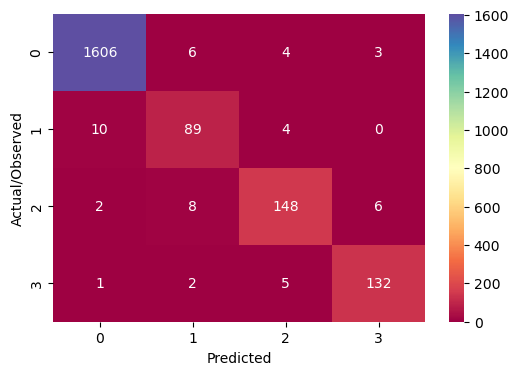

In [13]:
y_predicted = model_classs_wo_light.predict(X_test_wo_light)
cm = confusion_matrix(y_test_wo_light, y_predicted)
plt.figure(figsize = (6,4))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral",
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10);

In [14]:
print(classification_report(y_test_wo_light, y_predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1619
           1       0.85      0.86      0.86       103
           2       0.92      0.90      0.91       164
           3       0.94      0.94      0.94       140

    accuracy                           0.97      2026
   macro avg       0.92      0.93      0.92      2026
weighted avg       0.97      0.97      0.97      2026



In [15]:
# Saving the model with pickle
import pickle
filename = 'dt_classification_model.sav'
pickle.dump(model_classs_wo_light, open(filename, 'wb'))